# Labeled Component Unfolding (LCU)

O algoritmo LCU é um sistema dinâmico que pode ser aplicado numa rede complexa para resolver problemas semi-supervisionados. Seu funcionamento espelha-se em comportamentos da natureza e sistemas sociais, como sobrevivência, competição por recursos, exploração territorial e campanhas de eleição.

O autor desse algoritmo é brasileiro, Dr. Filipe Verri (ITA), sendo publicado como um artigo no IEEE (2016) e componente da sua tese de doutorado *Collective dynamics in complex networks for machine learning* (2018).

Diferentes de modelos de machine learning mais conhecidos, indutivos, onde há uma etapa prévia de aprendizado e então outra de predição, este algoritmo é classificado como **transdutivo**: o aprendizado ocorre sem a necessidade de estimar uma função de inferência, a classificação de pontos é feito diretamente! Ocorre uma etapa única, iterativa, de classificação. Para ilustrar a diferente entre algoritmos indutivos e transdutivos:

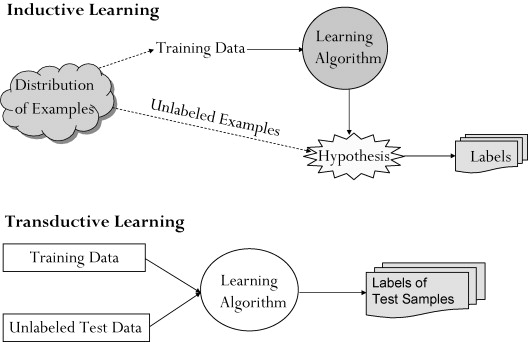

Nessa camada de resolução do problema de segmentação de imagem, já precisamos ter uma rede complexa formada, neste caso através de superpixels e extração de características para calcular o peso das arestas.

# Anotação de dados

Neste exemplo, por questões didáticas, irei gerar um grafo aleatório para facilitar a compreensão de funcionamento do algoritmo. Duas classes são anotadas, ciano de número 1 e vermelho de número 2. Os nós não anotados são cinzas.

In [1]:
import os
os.environ["LOGURU_LEVEL"] = "TRACE"
import random

import numpy as np
import networkx as nx
from egsis import EGSIS
from egsis import LCU
import matplotlib.pyplot as plt 



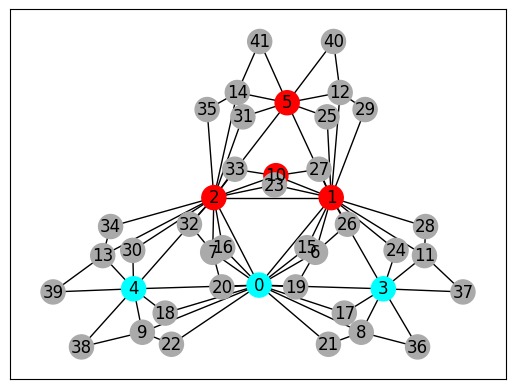

In [2]:

G = nx.dorogovtsev_goltsev_mendes_graph(4)
labels = {
    5: 2,
    10: 2,
    0: 1,
    4: 1,
    3: 1,
    2: 2,
    1: 2,
}
class_by_color = {
    1: "#00ffff", # cyan
    2: "#ff0000" # red
}
default = "#aaaaaa"
color_map = [class_by_color.get(labels.get(node), default)
             for node in G.nodes]
for node in G.nodes():
    G.nodes[node]["label"] = labels.get(node, 0)
    
for edge in G.edges:
    G.edges[edge]["weight"] = 1
    
nx.draw_networkx(G, node_color=color_map, pos=nx.spectral_layout(G))

# Classificação semi-supervisionada dos nós

Nesta etapa será executado a dinâmica coletiva LCU que consistet na expanção dos nós anotados como fontes de geração de paratículas (dessa cor) buscando dominar os próximos nós da redondeza num passeio aleatório baseado em sobrevivência. Existe alguns princípios:

1. Os nós chamados de "fonte", que são os anotados, geram particulas discriminados por classe.
2. Estas partículas possuem uma probabilidade de sobrevivência baseado no alvo e na existência de outras partículas rivais no alvo. Se essa particula cair numa fonte oposta ela morre. Um fator de sobrevivência $ \lambda $ de 0 a 1 é levado em consideração e quanto maior o degrau do nó, menor a chance de sucesso.
3. A dominância de arestas é proporcional a dominância direta do nó, no caso quantidade de partículas dessa classe no nó.
4. A dominância relativa se baseia na proporção de vezes que particulas de uma mesma cor passaram por esta aresta em algum sentido.

Considerando todos esses cenários, o algoritmo é executado iterativamente em um número fixo de vezes $ \tau $, no final é retornado segmentos do grafo por classe com arestas que tiveram maior dominância. 

In [9]:
lcu = LCU(n_classes=2, max_iter=1)
lcu.init(G)
N0 = lcu.N.copy()
sub_networks = lcu.fit_predict(G)
[g.remove_nodes_from(list(nx.isolates(g))) for g in sub_networks]

2023-11-12 00:08:30.142 | INFO     | egsis.lcu:__init__:91 - hyperparams: n_classes=2, competition_level=1, scale_particles=100, max_iter=1
2023-11-12 00:08:30.144 | DEBUG    | egsis.lcu:n0:220 - n0: classes=2, shape=(2, 42)
2023-11-12 00:08:30.146 | DEBUG    | egsis.lcu:n0:227 - n0: [[ 9.87654321  0.          0.          4.9382716   4.9382716   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.         19.75308642 19.75308642  0.          0.          9.87654321
   0.          0.          0.          0.          4.9382716   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         

[None, None]

# Visualização da classificação

Considerando o grafo anotado anterior, nesta etapa pode ser visto o resultado da classificação do o grafo final anotado e suas duas redes segmentadas por classe. Veja que em posições de fronteira as redes segmentadas compartilham nós. A resolução de fronteira é solucionada marcando o nó com a classe C ao escolher a classe que maximiza a seguinte equação:

$$ y_i = \underset{c \in \{1, ..., C\}}{arg\,max} \vert \mathcal{E}(\mathcal{N}_{c,j}) \vert$$

Sendo $y_i$ a label estimada, será escolhida a classe que tiver mais arestas na vizinhaça daquele nó.

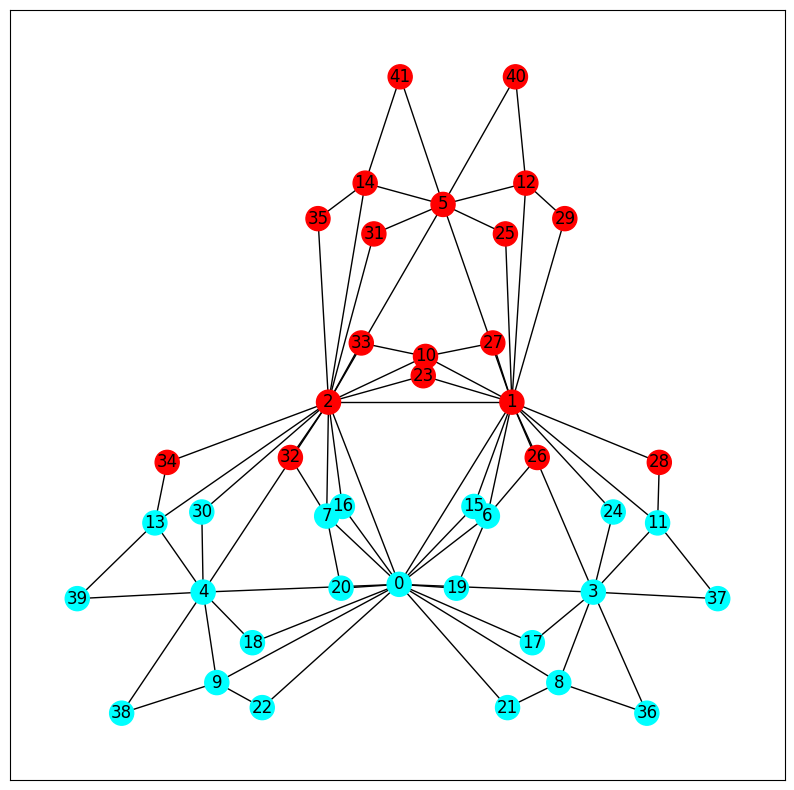

In [4]:
fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)
G_pred = lcu.classify_vertexes(sub_networks)
color_map = [class_by_color.get(G_pred.nodes.get(node)["label"], default)
             for node in G_pred.nodes]

nx.draw_networkx(G_pred, ax=ax, node_color=color_map,  pos=nx.spectral_layout(G_pred))

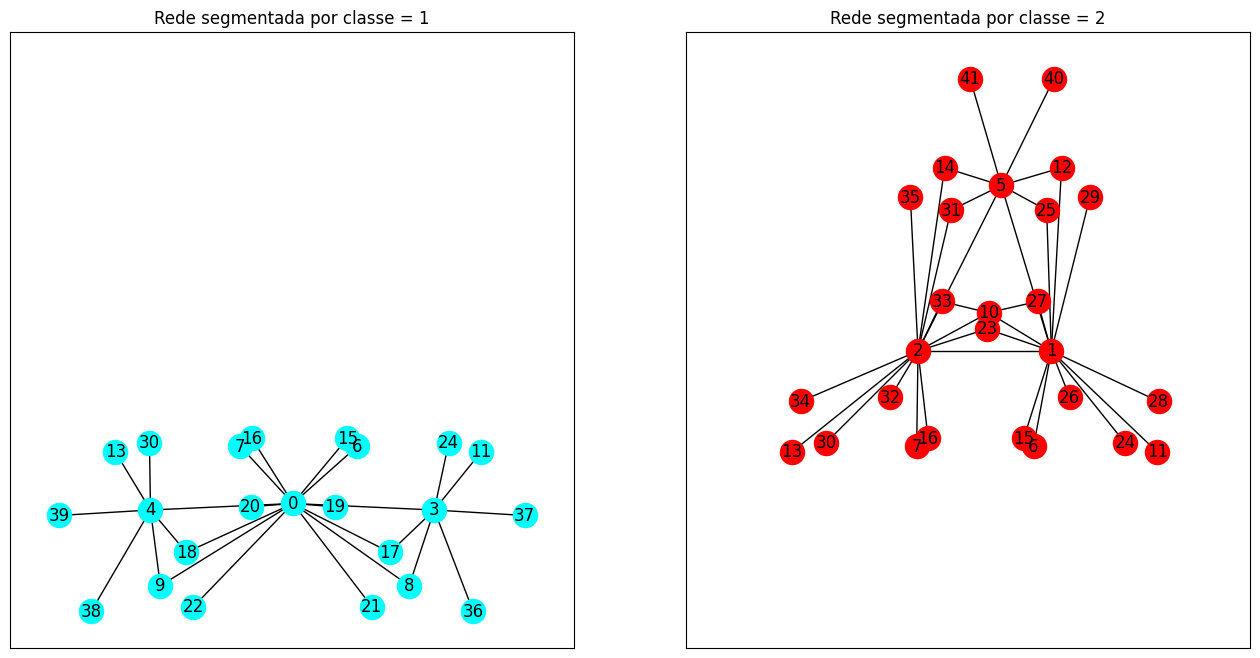

In [5]:

fig, ax = plt.subplots(1, len(sub_networks), figsize=(16, 8), sharex=True, sharey=True)
for sub_id in range(len(sub_networks)):
    ax[sub_id].set_title(f"Rede segmentada por classe = {sub_id + 1}")
    nx.draw_networkx(sub_networks[sub_id], ax=ax[sub_id], label="subnetworks", node_color=class_by_color[sub_id+1], pos=nx.spectral_layout(G_pred))

# 

In [11]:
np.array_equal(lcu.N, lcu.N)

True

In [13]:
[x for x in lcu.probability(G).flatten() if x != 0 ]

[0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.03125,
 0.03125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.03125,
 0.03125,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.0625,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.25,
 0.25,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125,
 0.125]

In [19]:
for (i, j) in G.edges:
    print(f"sigma[c=1] = {lcu.sigma(G, i, j, 0)}")
    print(f"sigma[c=2] = {lcu.sigma(G, i, j, 1)}")


sigma[c=1] = 0.5
sigma[c=2] = 0.5
sigma[c=1] = 0.5
sigma[c=2] = 0.5
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 0.0
sigma[c=2] = 1.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 0.5
sigma[c=2] = 0.5
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1.0
sigma[c=2] = 0.0
sigma[c=1] = 1